# Introduction
The problem we are tasked to tackle is to develop text and data mining tools that can help the medical community develop answers to high priority scientific questions.
We specifically focus on developing tools to answer questions related to "What do we know about vaccines and therapeutics?". We refer to this task as Task #4.

# Overview of Our Approach
We explain the approach we took to tackle this problem in 4 main steps: 
1. Preprocessing and exploring the data, 
2. Finding the most relevant articles using clustering and topic modeling approaches
3. Visualizing the significance of words in important topics
4. Creating a question answering system using Universal Sentence Embedding and ElasticSearch. 

The following figure explains these steps visually as well.
Observe that we combine the output of the clustering approach and the topic modeling approach to select the most relevent articles to Task #4.
Then, we further analyze the articles by looking at the citations used in each article.
The last step is to use the most relevant articles found in the previous steps to create a question answering system which finds the most relevant answer to specific questions within the topic of Task #4.

<figure>
    <img width="600" alt="Pipeline" src="https://user-images.githubusercontent.com/61748540/79469442-2c36c980-7fce-11ea-9bd5-77626334c277.png">
</figure>

# Step 0: Install the Required Packages

Here, we install all the required packages that are not already installed in this virtualenvironment.

In [1]:
%%capture
!pip install kmeanstf
!pip install tabulate
!pip install elasticsearch

# Step 1: Preprocessing and Data Exploration
In this section, we write some auxilary functions to read the CORD-19 dataset and store it in a format that will be used in the rest of this project.

### Import the Required Packages

In [8]:
import numpy as np
import pandas as pd 
import json
import os
import pickle
import time
import copy
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist 
import sklearn.metrics as metrics
import tensorflow as tf
from kmeanstf import KMeansTF
from tabulate import tabulate
from mpl_toolkits.mplot3d import Axes3D
import pylab
import matplotlib.cm as cm
import tensorflow.compat.v1 as tf
import tensorflow_hub as hub
from elasticsearch import Elasticsearch
from elasticsearch.helpers import bulk
from scipy import spatial

### Function to Read Input Data

This function reads the input data and collects all the relavant information about the articles in one dataframe.

In [9]:
def read_json_data(data_list, input_path): 
    '''
    Inputs: 
        - data_list: json file paths
        - input_path: input_path
        
    Output:
        - dataframe containing: 
              'paper_id', 
              'titles', 
              'abstracts', 
              'introductions', 
              'conclusions', 
              'full_bodytext', 
              'bodysections',
              'body_text_citations', 
              'context_title_list', 
              'cite_start', 
              'cite_end', 
              'cite_mark'
    This function is used to parse json files to return the output elements
    '''
    
    bibentries_title = []
    bibentries_token = []
    for json_file in range(0, len(data_list)):
        bibentries_token.append(list(data_list[json_file]['bib_entries'].keys()))

    for token_num, token_list in enumerate(bibentries_token):
        bibentry_title = []
        for token_len, token in enumerate(token_list):
            bibentry_title.append(data_list[token_num]['bib_entries'][token]['title'])
        bibentries_title.append(bibentry_title)
        
    titles = []
    all_info = []
    paper_id = []
    search_abstracts = []
    for json_file in range(0, len(data_list)):
        paper_id.append(data_list[json_file]['paper_id'])
        titles.append(data_list[json_file]['metadata']['title'])
        all_info.append(data_list[json_file]['body_text'])
        try:
            search_abstracts.append(data_list[json_file]['abstract'])
        except IndexError:
            search_abstracts.append(None)
        except KeyError:
            search_abstracts.append(None)

    abstracts = []
    for texts in search_abstracts:
        local_abstract = []
        if texts is not None:
            for num in range(0, len(texts)):
                local_abstract.append(texts[num]['text'])
        abstracts.append(' '.join(local_abstract))

    bodysections = []
    full_bodytext = []
    introductions = []
    conclusions = []
    cite_tokens = []
    cite_start = []
    cite_end = []
    cite_mark = []
    
    for text_info in all_info:
        local_info = []
        local_cite_token = []
        local_cite_start = []
        local_cite_end = []
        local_cite_mark = []
        local_introduction = []
        local_conclusion = []

        for info_len in range(0, len(text_info)):
            if text_info[info_len]['section'] == 'Introduction':
                local_introduction.append(text_info[info_len]['text'])
            elif text_info[info_len]['section'] == 'Conclusion':
                local_conclusion.append(text_info[info_len]['text'])
            local_info.append(text_info[info_len]['text'])
        for indices in text_info:
            for cite_spans in indices['cite_spans']:
                local_cite_token.append(cite_spans['ref_id'])
                local_cite_start.append(cite_spans['start'])
                local_cite_end.append(cite_spans['end'])
                try:
                    local_cite_mark.append(cite_spans['text'])
                except KeyError:
                    local_cite_mark.append(None)
        introductions.append(''.join(local_introduction))
        conclusions.append(''.join(local_conclusion))
        full_bodytext.append(' '.join(local_info))
        bodysections.append(local_info)
        cite_tokens.append(local_cite_token)
        cite_start.append(local_cite_start)
        cite_end.append(local_cite_end)
        cite_mark.append(local_cite_mark)

    bib_dict_list = []
    for bib_ref, bib_ttl in (zip(bibentries_token, bibentries_title)):
        bib_dict = {}
        for bib_bib_ref, bib_bib_ttl in zip(bib_ref, bib_ttl):
            bib_dict[bib_bib_ref] = bib_bib_ttl
        bib_dict_list.append(bib_dict)

    context_title_list = []
    for cite_val, bib_val in (zip(cite_tokens, bib_dict_list)):
        cite_set = cite_val
        bib_set = set(bib_val)
        context_title_temp = []
        for value in cite_set:
            for val in bib_set:
                if value == val:
                    context_title_temp.append(bib_val[value])
                elif value == None:
                    context_title_temp.append(None)
                    break
        context_title_list.append(context_title_temp)
        
    
    fields = {
              'paper_id': paper_id[0], 
              'titles': titles[0], 
              'abstracts': abstracts[0], 
              'introductions': introductions[0], 
              'conclusions': conclusions[0], 
              'full_bodytext': full_bodytext[0], 
              'bodysections': bodysections[0],
              'context_title_list': context_title_list[0], 
              'cite_start': cite_start[0], 
              'cite_end': cite_end[0], 
              'cite_mark': cite_mark[0]
            }
    return fields

### Store the Data

Here, we store the preprocessed data for further investigation. We have ignored some articles that do not have a valid path to a full text article. 

In [10]:
input_path = 'CORD-19-research-challenge/'

start = time.time()
f_name_list = ['biorxiv_medrxiv/biorxiv_medrxiv', 'comm_use_subset', 'noncomm_use_subset', 'custom_license/custom_license']
files = []
for f_name in f_name_list:
    for root, dirs, file in os.walk(input_path + f_name):
        for fname in file:
            files.append(os.path.abspath(os.path.join(root, fname)))  

file_list = []
folder_list = []
for l in files:
    with open(l) as json_data_l:
        data_list = json.load(json_data_l)
        context_data = read_json_data([data_list], input_path=input_path)
    file_list.append(context_data)
folder_list.append(file_list)

flatten_data = [item for sublist in folder_list for item in sublist]
context_data = pd.DataFrame.from_dict(flatten_data)

print('Elapsed time: ', time.time() - start)

pickle.dump(context_data, open('context_data.df', 'wb'))
print('Data file size: ', os.path.getsize('context_data.df')/(1024*1024))

Elapsed time:  42.5830454826355
Data file size:  2276.3125591278076


### Look at the Data

Here, we provide the first and last few rows of the dataframe that we just created to make sure everything looks fine. 

In [5]:
context_data.head(3)

,paper_id,titles,abstracts,introductions,conclusions,full_bodytext,bodysections,context_title_list,cite_start,cite_end,cite_mark
0,f9c6a656d0ce352cc1fa0df8d83e6d4a1f53d7c2,Estimating the Case Fatality Risk of COVID-19 ...,There is large uncertainty around the case fat...,,,The new coronavirus appears to be fairly trans...,[The new coronavirus appears to be fairly tran...,[Epidemiological research priorities for publi...,"[55, 178, 694, 125, 606, 38, 459, 785, 1313, 1...","[58, 181, 697, 128, 609, 41, 462, 789, 1317, 1...","[[1], [1], [2], [3], [7], [8], [9], [10], [11]..."
1,982a6fe2fdba30430b547741811ff4411f1485f1,Molecular basis for the evolution of species-s...,Metals are a limiting resource for pathogenic ...,,,Animals possess a variety of molecular factors...,[Animals possess a variety of molecular factor...,"[None, None, None, None, None, None, None, Non...","[718, 1661, 847, 852, 529, 539, 659, 64, 69, 7...","[737, 1675, 851, 855, 538, 542, 670, 68, 72, 7...","[(Supplemental Data), S. aureus. 193, (43,, 44..."
2,8b88d01563538e4abd29c3ba493c534af30664cc,A mathematical model for simulating the transm...,"bioRxiv preprint 2 this study, we developed a ...","On 31 December 2019, the World Health Organiza...",,"On 31 December 2019, the World Health Organiza...","[On 31 December 2019, the World Health Organiz...","[Pneumonia of Unknown Etiology in Wuhan, China...",[409],[412],[(2)]


# Step 2: Find the Most Relevant Articles to Task #4

We first apply the TF-IDF vectorizer to map the articles (including abstract, introduction, body, and conclusion) to vectors representing their contents. We then use these vectors as features for each article and then apply the k-means clustering algorithm to cluster all the articles in the dataset. For this specifc problem, we choose the number of clusters to be 10 since we have 10 different tasks which have relatively low overlap in terms of the discussed topic.

Furthermore, we also find a set of articles that are most relevant to Task #4 by performing a Topic Modeling (TM) analysis. 
After finding the most relavant articles using the TM analysis, we find the cluster (obtained from k-means clustering) that has the most overlap with the selected articles using the TM approach. We use this subset of articles as the input for the next step.

## Step 2 - Table of Contents
* [Extract features and apply k-means clustering on all articles](#STEP1-1-bullet)
* [How to interpret the clutering results?](#STEP1-2-bullet)
* [Topic Modeling](#STEP1-3-bullet)


## Extract features and apply k-means clustering on all articles <a class="anchor" id="STEP1-1-bullet"></a>

To extract features for each article using a set of specific parts (i.e., abstract, intorduction, body text, conclusion) we use the Term Frequency–Inverse Document Frequency (TF-IDF) approach. Use the *TfidfVectorizer* package of *sklearn* to get the TF-IDF vector. We consider all parts of the papers to be considered in this mapping. We also set the maximum number of features to be 4000 to limit the required computational power. In future studies, we will experiment with increasing this number to see if we can also improve the accuracy of the downstream tasks.

### Function to create feature vectors using TF-IDF vectorizer

In [6]:

def create_features_tfidf(data, columns=['title'], max_features=None):
    corpus = pd.DataFrame(columns=['text'])
    corpus['text'] = data[columns].dropna().agg('\n'.join, axis=1)
    
    vectorizer = TfidfVectorizer(stop_words='english', max_features=max_features)

    x = vectorizer.fit_transform(corpus['text'].values)
    
    return x, vectorizer


### Apply the TF-IDF Vectorizer to abstract, introduction, body text, and conclusion of all the articles

Please note that we set the maximum number of features to 100 only due to the computational time while submitting the notebook for this competition. The rest of the analysis has been done while the *max_features* parameter is set to 4000. Future work also explores setting higher values for this hyperparameter to see if we gain any accuracy while performing the clustering.

In [7]:

columns_to_consider = ['titles', 'abstracts', 'full_bodytext']
x, vectorizer = create_features_tfidf(context_data, columns=columns_to_consider, max_features=100)

print(x.shape)
pickle.dump(x, open('tfidf_matrix.pkl', 'wb'))

(33375, 100)


### Run KMeans algorithm on the extracted features

Here we use a TensorFlow-based implementation of k-means (<a href="https://pypi.org/project/kmeanstf/" target="_blank">KMeansTF</a>) to perform the clustering. We also use two different metrics to see how well these articles are grouped together. We use <a href="https://en.wikipedia.org/wiki/Davies–Bouldin_index" target="_blank">Davies–Bouldin index (DBI)</a> and the <a href="https://en.wikipedia.org/wiki/Silhouette_(clustering)" target="_blank">Silhouette score</a> to quantify the goodness of these clusters. Although, the scores do not show great performance, we can consider these clusters relatively good.

In [8]:
features = tf.convert_to_tensor(x.toarray(), dtype=tf.float32)
km = KMeansTF(n_clusters=10, random_state=1)
km.fit(features)
labels = km.predict(x.toarray())
s_score = metrics.silhouette_score(x.toarray(), labels)
db_score = metrics.davies_bouldin_score(x.toarray(), labels)

print(s_score, db_score)
pickle.dump([km, labels], open('clustering_kernel.pkl', 'wb'))

0.12741524270792487 2.5497073720837453


### Reduce the dimension of the feature space to visualize the results in 2D/3D dimensions

We use two different methods to reduce the dimension of the feature space from 4000 down to 2 and 3. These two methods are <a href="https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding" target="_blank">t-distributed Stochastic Neighbor Embedding (t-SNE)</a> and <a href="https://en.wikipedia.org/wiki/Principal_component_analysis" target="_blank">Principal Component Analysis (PCA)</a> which are two commonly used approaches for this purpose. Observe that the obtained figures show that the similar articles have been well clustered together. 

The following code has been provided to perform the dimensionality reduction. 


Text(0.5, 1.0, 'PCA')

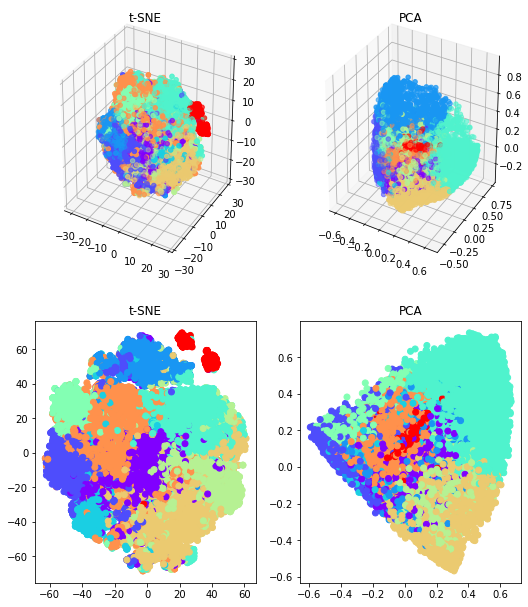

In [9]:
[km, labels] = pickle.load(open('clustering_kernel.pkl', 'rb'))
x = pickle.load(open('tfidf_matrix.pkl', 'rb'))

colors = cm.rainbow(np.linspace(0, 10, 100))


################### 3D Visualization ######################
# Use t-SNE to reduce dimensions down to 3
tsne = TSNE(n_components=3, verbose=0).fit(x)
tsne_vec_3d = tsne.embedding_

fig = plt.figure(figsize=(10, 10))
plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)
ax_3d = fig.add_subplot(2, 2, 1, projection='3d')
ax_3d.scatter(tsne_vec_3d[:, 0], tsne_vec_3d[:, 1], tsne_vec_3d[:, 2], c=colors[labels-1])#c=kernel.labels_*100, cmap=pylab.cm.cool)
ax_3d.set_title('t-SNE')


# Use PCA to reduce dimensions down to 3
pca = PCA(n_components=3)
pca.fit(x.toarray())
#print('Explained variance ratio of the first three PCs: ', pca.explained_variance_ratio_)
pca_vec_3d = pca.transform(x.toarray())

ax_3d = fig.add_subplot(2, 2, 2, projection='3d')
ax_3d.scatter(pca_vec_3d[:, 0], pca_vec_3d[:, 1], pca_vec_3d[:, 2], c=colors[labels-1])
ax_3d.set_title('PCA')



################### 2D Visualization ######################
# Use t-SNE to reduce dimensions down to 2
tsne = TSNE(n_components=2, verbose=0).fit(x)
tsne_vec_2d = tsne.embedding_

ax_2d=plt.subplot(2, 2, 3)
ax_2d.scatter(tsne_vec_2d[:, 0], tsne_vec_2d[:, 1], c=colors[labels-1])
ax_2d.set_title('t-SNE')


# Use PCA to reduce dimensions down to 2
pca = PCA(n_components=2).fit(x.toarray())
#print('Explained variance ratio of the first two PCs: ', pca.explained_variance_ratio_)
pca_vec_2d = pca.transform(x.toarray())

ax_2d=plt.subplot(2, 2, 4)
ax_2d.scatter(pca_vec_2d[:, 0], pca_vec_2d[:, 1], c=colors[labels-1])
ax_2d.set_title('PCA')


## How to interpret the clutering results? <a class="anchor" id="STEP1-2-bullet"></a>

As mentioned earlier, the motivation behind choosing the number of clusters to be 10 is that we would like to work with the articles that are more relevant to Task #4. However, by simply applying a clustering algorithm, it is hard to tell which cluster corresponds to which general topic. Therefore, we propose to perform a Topic Modeling on all parts of the articles to obtain the most relevant articles to Task #4. Next, we find the cluster that has the most overlap with the relavant articles obtained from Topic Modeling. Then, we take the union of these two sets (the chosen cluster and the set of important articles obtained by Topic Modeling) and use those articles for the downstream tasks since we are focusing on answering specific questions stated in Task #4. In the next section, we explain how we obtain the most relevant articles using topic modeling.

## Topic Modeling<a class="anchor" id="STEP1-3-bullet"></a>

One of the well-known generative probabilistic topic modeling algorithms is the <a href="https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation" target="_blank">Latent Dirichlet Allocation (LDA)</a> approach which performs well in finding topics in a collection of documents.
In LDA, topics are the latent variables, while words are the apparent variables. 
LDA receives words as an input vector and generates topics which are probability distribution over words based on a generative process. LDA uses a joint probability distribution over both the observed and hidden random variables and compute the posterior distribution (conditional distribution) of the hidden variables given the observed variables. 
The fundamental assumption of LDA is that documents can be assigned to multiple topics. Another assumption is that topics are hidden variables and words in documents are apparent variables. Thus, LDA performs a generative process by receiving words as an input vector to provide topics which are probability distribution over words.  The aim is that we provide a list of keywords that are relvent to Task#4. 
Here, we explain how we can apply this method to our problem.




**Import the Required Packages**

In [10]:
import os
import glob
import json
import pickle
import re
import logging
import gensim
import pandas
import pandas as pd
import timeit
from tqdm import tqdm
from pprint import pprint
from gensim import corpora, models
from gensim.models.ldamodel import LdaModel
from gensim.models.phrases import Phrases, Phraser
from gensim.utils import simple_preprocess
from gensim.models.coherencemodel import CoherenceModel
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/18rvb/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [11]:
doc = ['Efforts targeted at a universal coronavirus vaccine.',
'Exploration of use of best animal models and their predictive value for a human vaccine.',
'Methods evaluating potential complication of Antibody Dependent Enhancement (ADE) in vaccine recipients.',
'Approaches to evaluate risk for enhanced disease after vaccination',
'Effectiveness of drugs being developed and tried to treat COVID-19 patients.',
'Clinical and bench trials to investigate less common viral inhibitors against COVID-19 such as naproxen, clarithromycin, and minocycline that may exert effects on viral replication.',
'Capabilities to discover a therapeutic (not vaccine) for the disease, and clinical effectiveness studies to discover therapeutics, to include antiviral agents.',
'Alternative models to aid decision makers in determining how to prioritize and distribute scarce, newly proven therapeutics as production ramps up. This could include identifying approaches for expanding production capacity to ensure equitable and timely distribution to populations in need.',
'Efforts to develop animal models and standardize challenge studies',
'Efforts to develop prophylaxis clinical studies and prioritize in healthcare workers',
'Assays to evaluate vaccine immune response and process development for vaccines, alongside suitable animal models (in conjunction with therapeutics)',]

In [12]:
words=[]
for ch in doc: 
    words.append(ch.split(' '))


words = [row.split() for row in doc]


bigram = Phrases(words, min_count=30, progress_per=1000)
bigram_mod = Phraser(bigram)

bigrams = [b for l in doc for b in zip(l.split(" ")[:-1], l.split(" ")[1:])]

In [13]:
stop_words = stopwords.words('english')
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

words_nostops = remove_stopwords(words)

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]
words_bigrams = make_bigrams(words_nostops)

id2word = corpora.Dictionary(words_bigrams)

texts = words_bigrams
corpus = [id2word.doc2bow(text) for text in texts]

lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=17, 
                                       random_state=10,
                                       chunksize=5,
                                       passes=1,
                                       per_word_topics=True)
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.011*"vaccine" + 0.011*"efforts" + 0.011*"models" + 0.011*"effectiveness" '
  '+ 0.011*"disease" + 0.011*"clinical" + 0.011*"develop" + 0.011*"drugs" + '
  '0.011*"studies" + 0.011*"animal"'),
 (1,
  '0.011*"efforts" + 0.011*"vaccine" + 0.011*"universal" + 0.011*"animal" + '
  '0.011*"studies" + 0.011*"develop" + 0.011*"models" + 0.011*"conjunction" + '
  '0.011*"coronavirus" + 0.011*"assays"'),
 (2,
  '0.011*"vaccine" + 0.011*"animal" + 0.011*"efforts" + 0.011*"models" + '
  '0.011*"evaluate" + 0.011*"disease" + 0.011*"develop" + 0.011*"studies" + '
  '0.011*"clinical" + 0.011*"capabilities"'),
 (3,
  '0.111*"discover" + 0.057*"agents" + 0.057*"therapeutic" + 0.057*"studies" + '
  '0.057*"clinical" + 0.057*"effectiveness" + 0.057*"antiviral" + '
  '0.057*"include" + 0.057*"capabilities" + 0.057*"therapeutics"'),
 (4,
  '0.095*"models" + 0.095*"animal" + 0.049*"best" + 0.049*"develop" + '
  '0.049*"vaccine" + 0.049*"use" + 0.049*"human" + 0.049*"predictive" + '
  '0.049*"chall

In [14]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=words_bigrams):
    sent_topics_df = pandas.DataFrame()
    
    keywords_arr = []

    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                keywords_arr.append(topic_keywords)
                sent_topics_df = sent_topics_df.append(pandas.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    contents = pandas.Series(texts)
    sent_topics_df = pandas.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df, keywords_arr)

In [15]:
df_topic_sents_keywords, keywords_arr = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=words_bigrams)

result = []
keywords_arr = [i.lower().replace(',', '').split() for i in keywords_arr]


result = [x for sublist in keywords_arr for x in sublist]

keywords = result

In [16]:
#Part #2
print('----------------------------------------------------------------------------')
colnames = ['sha','source_x','title','doi','pmcid','pubmed_id','license','abstract','publish_time','authors','journal','Microsoft Academic','Paper ID','WHO #Covidence','has_full_text','full_text_file']
data = pandas.read_csv('CORD-19-research-challenge/metadata.csv', dtype=str, names=colnames, low_memory=False)
documents = data.title


data = data.drop(columns=['sha', 'source_x', 'doi', 'pmcid', 'pubmed_id', 'license', 'abstract', 'publish_time', 'authors', 'journal', 'Microsoft Academic', 'WHO #Covidence', 'has_full_text', 'full_text_file'], axis=1)
data['title_processed'] = data['title'].map(lambda x: re.sub('[,\.!?]', '', str(x)))


----------------------------------------------------------------------------


In [17]:
data_path = 'CORD-19-research-challenge/'
json_files = glob.glob(f'{data_path}/**/**/*.json', recursive=True)

In [18]:
# the columns would be title, paper id
def to_covid_json(json_files):
    jsonl = []
    for file_name in tqdm(json_files):
        try:
            row = {"doc_id": None, "title": None, "abstract": None, "body": None}
            with open(file_name) as json_data:
    #             print(file_name)
    #             break
                data = json.load(json_data)
                row['doc_id'] = data['paper_id']
                row['title'] = data['metadata']['title']

                abstract_list = [abst['text'] for abst in data['abstract']]
                abstract = "\n".join(abstract_list)
                row['abstract'] = abstract
                # And lastly the body of the text. 
                body_list = [bt['text'] for bt in data['body_text']]
                body = "\n".join(body_list)
                row['body'] = body
        except KeyError:
            continue
        jsonl.append(row)
    
    return jsonl
def get_data():
    try:
        with open('df_cache.pickle', 'rb') as f:
            df = pickle.load(f)
    except:
        df = pd.DataFrame(to_covid_json(json_files))
        with open('df_cache.pickle', 'wb') as f:
            pickle.dump(df, f)
    return df

In [20]:
Dic_title_to_key={}
df = get_data()
for i in range(len(df.body)):
    for item in keywords:
        if item.lower() in df.body[i].lower():
            Dic_title_to_key[df.title[i]]=item
df2=pd.DataFrame(Dic_title_to_key.items(), columns=['title', 'keyword'])
df3=pd.merge(df2, data, on='title')
df3 = df3.sort_values('keyword').reset_index().drop(columns=['index'])
df3.to_csv (r'export_dataframe.csv', index = False, header=True)

## Find the cluster that has the most overlap with the most relevant articles

In order to do so, we find the overlap between the most important articles and each individual cluster. We also find the intersection and union of these two sets for all the 10 different clusters.

In [21]:

[km, labels] = pickle.load(open('clustering_kernel.pkl', 'rb'))

clustering_data = context_data[columns_to_consider].dropna().reset_index()
clustering_data['label'] = labels

tm_data = pd.read_csv('export_dataframe.csv')
tm_titles = set(tm_data['title'].values)

table = []
for l in np.unique(labels):
    label_data = clustering_data[clustering_data['label'] == l]
    label_titles = set(label_data['titles'].values)

    selected_articles_i = tm_titles.intersection(label_titles)
    selected_articles_u = tm_titles.union(label_titles)
    table.append([l, len(label_titles), len(selected_articles_i), len(selected_articles_u)])

print(tabulate(table, headers=["Cluster ID","# of Articles", "Intersection", "Union"]))


  Cluster ID    # of Articles    Intersection    Union
------------  ---------------  --------------  -------
           0              379              89    17253
           1             3483            2332    18114
           2             2462            1354    18071
           3             2146            1316    17793
           4             1233             720    17476
           5             4740            2974    18729
           6             1287             646    17604
           7             3327            1956    18334
           8             4952            2913    19002
           9             4904            2696    19171


Observe the cluster which has the largest number of articles in the intersection (Cluster ID #5) with the most important results. Therefore, we choose this cluster and find the union of the articles in this cluster with the most relevant articles to create a set of articles that are the most important for Task #4.

In [22]:
l = 3
label_data = clustering_data[clustering_data['label'] == l]
label_titles = set(label_data['titles'].values)

selected_articles_i = set(tm_titles.intersection(label_titles))
selected_articles_u = set(tm_titles.union(label_titles))

selected_articles = clustering_data[clustering_data['titles'].isin(selected_articles_u)]
selected_articles = selected_articles.filter(items=['titles', 'sha'])

pickle.dump(selected_articles, open('selected_articles.pkl', 'wb'))


Moving forward, we consider this set of articles to use for making the queries.

# Step 3: Visualizing the Significance of Words in Important Topics

We identify some important topics from the task description of the challenge and after preprocessing (removal of stopwords and punctuation), we are able to visualize it by an InferSent model trained on the titles of our dataset.

**Tokenize sentences, remove stop words and punctuation**

In [23]:
from nltk.tokenize import word_tokenize
import string

tokenized_words = []
for words in doc:
    tokenized_words.append(word_tokenize(words))
    
wordsFiltered = []

for l in tokenized_words:
    temp_list = []
    for w in l:
        if w not in stop_words:
            temp_list.append(w)
    wordsFiltered.append(temp_list)
    
search_sentences = []
for i in wordsFiltered:
    search_sentences.append(' '.join(i))

remove_punct = []
for s in search_sentences:
    remove_punct.append(s.translate(str.maketrans('', '', string.punctuation)))

**Clone the InferSent repo and download the InferSent model trained with fasttext**

In [24]:
# !git clone https://github.com/facebookresearch/InferSent.git
from InferSent.models import InferSent
import nltk
import torch
nltk.download('punkt')   

!mkdir encoder
!curl -Lo encoder/infersent2.pkl https://dl.fbaipublicfiles.com/infersent/infersent2.pkl

[nltk_data] Downloading package punkt to /home/18rvb/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
mkdir: cannot create directory ‘encoder’: File exists
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  146M  100  146M    0     0  7930k      0  0:00:18  0:00:18 --:--:-- 8461k


**Load pre-trained model and update the vocabulary with most common words**

In [25]:
V = 2
MODEL_PATH = 'encoder/infersent%s.pkl' % V
params_model = {'bsize': 64, 'word_emb_dim': 300, 'enc_lstm_dim': 2048,
                'pool_type': 'max', 'dpout_model': 0.0, 'version': V}
infersent = InferSent(params_model)
infersent.load_state_dict(torch.load(MODEL_PATH))

W2V_PATH = 'fastText/crawl-300d-2M.vec'
infersent.set_w2v_path(W2V_PATH)

infersent.build_vocab_k_words(K=100000)

Vocab size : 100000


**Update vocabulary with titles from CORD-19 dataset**

In [26]:
string_titles = []
for sent in list(context_data['titles']):
    if isinstance(sent, str):
        string_titles.append(sent)

infersent.update_vocab(string_titles)

Found 14318(/27385) words with w2v vectors
New vocab size : 114321 (added 14318 words)


**Visualize a few important topics**

We can clearly see that based on the vector representations created from using fasttext embeddings on titles in our dataset, and visualizing important terms specific to task-4, **"vaccine"**, it's derivative words, and **"coronavirus"** are important words contributing towards generating embeddings. This handy function can be used to identify the significance of several other important topics from a model trained in an unsupervised manner to create embeddings on a related corpora, which in this case is titles from the CORD-19 dataset.

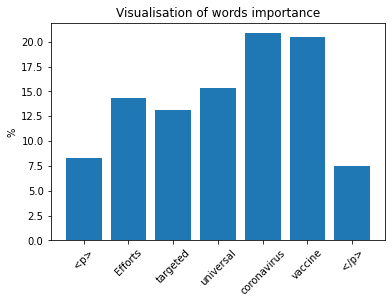

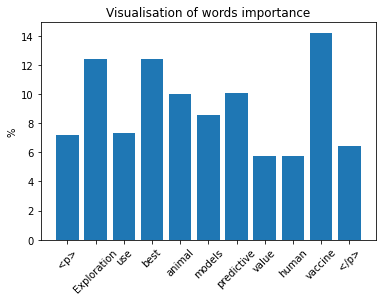

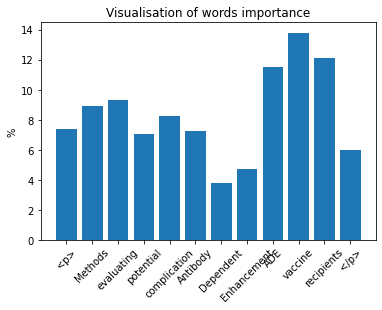

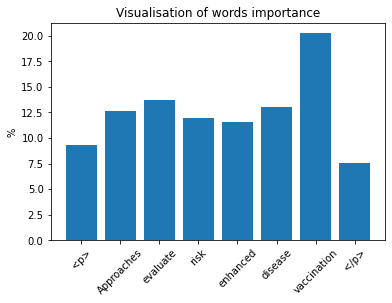

In [27]:
for topic in remove_punct[:4]:
    infersent.visualize(topic, tokenize=True)

# Step 4: Find the most Relevant Answers to Specific Queries

By following the previous steps, we can identify the articles that are most relevant to the questions asked in Task 4, now we need an efficient way to query the articles and return the most relevant ones to answer a question entered by the end user. To achieve that, we select Elastisearch as our search engine and utilize the dense vector data type to store vector representation of the text to allow better document scoring. The details of this part will be introduced as the following table of content.

## Step 4 - Table of Contents
* [Install Elasticsearch](#STEP4-1-bullet)
* [Create Index Mapping](#STEP4-2-bullet)
* [Download Universal Sentence Encoder for text embedding](#STEP4-3-bullet)
* [Start Indexing](#STEP4-4-bullet)
* [Start Querying](#STEP4-5-bullet)

### Install Elasticsearch <a class="anchor" id="STEP4-1-bullet"></a>

As mentioned before, we want to create vector representations for text and use them to allow better document scoring when searching answers for a query, we need to install Elasticsearch service with version higher than 7.6. Here is the link to download the package: https://www.elastic.co/start.  

On the download page, there are instructions to install Elasticsearch. Once you download the packages, make sure to run: <br>
`bin/elasticsearch` to start the elasticsearch service. To make sure the service is up and running, you can open http://localhost:9200 in your browser, you should get response like the following:

    `{
      "name" : "cluster_name",
      "cluster_name" : "elasticsearch",
      "cluster_uuid" : "1MVhoZ9HS4GcGRppF4P-yQ",
      "version" : {
        "number" : "7.6.1",
        "build_flavor" : "default",
        "build_type" : "tar",
        "build_hash" : "aa751e09be0a5072e8570670309b1f12348f023b",
        "build_date" : "2020-02-29T00:15:25.529771Z",
        "build_snapshot" : false,
        "lucene_version" : "8.4.0",
        "minimum_wire_compatibility_version" : "6.8.0",
        "minimum_index_compatibility_version" : "6.0.0-beta1"
      },
      "tagline" : "You Know, for Search"
    }`
   

### Create Index Mapping <a class="anchor" id="STEP4-2-bullet"></a>

We need to create a mapping schema to tell elasticsearch what information from each article we want to store and what data type we want to use. For this submission, we store the 'paper_id' as the _keyword_ type, the 'title' and 'abstract' as the _text_ type, the vector representation of 'title' and 'abstract' as the <em>dense_vector</em> type. 

In [14]:
index_mappings = {
      "settings": {
          "number_of_shards": 2,
          "number_of_replicas": 1
        },
       "mappings": {
          "dynamic": "true",
           "_source": {
                 "enabled": "true"
             },
          "properties": {
              "paper_id": {
                  "type": "keyword"
              },  
              "title": {
                  "type": "text"
              },
              "abstract": {
                  "type": "text"
              },
              "title_vector": {
                "type": "dense_vector",
                "dims": 512
              },
              "abstract_vector": {
                "type": "dense_vector",
                "dims": 512
              }
            }
          }
        }

### Download Universal Sentence Encoder for text embedding <a class="anchor" id="STEP4-3-bullet"></a>

To obtain the vector representations for texts, we need to apply the sentence embedding technique. There are various sentence embedding methods such as SIF embedding[1], or using BERT[2], or InferSent[3] etc.. In this work, we choose to use Google's Universal Sentence Encoder[4]. However, investigating in other methods is the priority in our future work, particularly applying BioBERT as a service.

In [3]:
%%capture
import sys
!{sys.executable} -m pip install tensorflow_hub
!{sys.executable} -m pip install tensorflow

** Note: It will take a few minutes to download the universal sentence encoder model from the tensorflow hub. So grab a cup of coffee and come back :) **

In [2]:
# Create graph and finalize (finalizing optional but recommended).
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="0"

g = tf.Graph()
with g.as_default():
# We will be feeding 1D tensors of text into the graph.
    text_input = tf.placeholder(dtype=tf.string, shape=[None])
    embed = hub.Module("https://tfhub.dev/google/universal-sentence-encoder/2")
    embeddings = embed(text_input)
    init_op = tf.group([tf.global_variables_initializer(), tf.tables_initializer()])
g.finalize()
# Create session and initialize.
session = tf.Session(graph=g)
session.run(init_op)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [5]:
# Use tensorflow for the Universal Sentence Encoder
GPU_LIMIT = 0.5
tf.compat.v1.disable_eager_execution()
print("Downloading pre-trained embeddings from tensorflow hub...")
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/2") # You can also download the model and reload it from your path
text_ph = tf.placeholder(tf.string)
embed = embed.signatures['default']
embeddings = embed(text_ph)
print("Done.")
print("Creating tensorflow session...")
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = GPU_LIMIT
session = tf.Session(config=config)
session.run(tf.global_variables_initializer())
session.run(tf.tables_initializer())
print("Done.")

Done.
Creating tensorflow session...
Done.


### Start Indexing <a class="anchor" id="STEP4-4-bullet"></a>

In [6]:
# Uncomment the following to install the elasticsearch python package
import sys
!{sys.executable} -m pip install elasticsearch

You should consider upgrading via the '/home/18rvb/anaconda3/bin/python -m pip install --upgrade pip' command.


**Get articles that are relevant to Task 4**

In [11]:
articles_list = "./selected_articles.pkl"
articles_df = pd.read_pickle(articles_list)
titles = articles_df['titles'].tolist()
print(len(titles))

22006


**Load articles**

In [12]:
def load_article(context_data, title):
    doc = context_data[context_data['titles'] == title]
    try:
        return doc.iloc[0]
    except:
        return None

**Create Index**

In [15]:
INDEX_NAME = "covid19"
INDEX_Mappings = index_mappings

BATCH_SIZE = 1000 # The batch size for bulk indexing

client = Elasticsearch() # Connect to the elasticsearch service we started earlier
client.indices.delete(index=INDEX_NAME, ignore=[404]) # Delete the index if it exists
client.indices.create(index=INDEX_NAME, body=INDEX_Mappings)

{'acknowledged': True, 'shards_acknowledged': True, 'index': 'covid19'}

**Extract content of interest from the original article json file and apply sentence embedding**

In [16]:
# Embedding method
def embed_text(text):
    vectors = session.run(embeddings, feed_dict={text_ph: text})
    return [vector.tolist() for vector in vectors['default']]

In [17]:
# Extract content and apply sentence embedding, then bulk index
def index_batch(docs):
    titles = [doc["titles"] for doc in docs]
    title_vectors = embed_text(titles)
    
    abstracts = [doc["abstracts"] for doc in docs]
    abstract_vectors = embed_text(abstracts)

    requests = []
    for i, doc in enumerate(docs):
        request = {}
        request['paper_id'] = doc['paper_id']
        request['title'] = titles[i] 
        request['abstract'] = abstracts[i]
        request["_op_type"] = "index"
        request["_index"] = INDEX_NAME
        request["title_vector"] = title_vectors[i]
        request["abstract_vector"] = abstract_vectors[i]
        requests.append(request)
    bulk(client, requests)

**Note: The indexing process will take some time depending on the number of articles you'd like to index, but this is one time effort, once the articles are indexed, the searching process is fast**

In [18]:
docs = []
count = 0

start_time = time.time()
print(len(titles))
for title in titles:
    doc = load_article(context_data, title)
    
    if doc is None:
        continue
    docs.append(doc)
    count += 1

    if count % BATCH_SIZE == 0:
        print(count)
        index_batch(docs)
        docs = []
        print("Indexed {} documents.".format(count))

if docs:
    index_batch(docs)
    print("Indexed {} documents.".format(count))

client.indices.refresh(index=INDEX_NAME)
print("Done indexing.")
end_time = time.time()
print("Time to index: ", (end_time - start_time)/3600)

22006
1000
Indexed 1000 documents.
2000
Indexed 2000 documents.
3000
Indexed 3000 documents.
4000
Indexed 4000 documents.
5000
Indexed 5000 documents.
6000
Indexed 6000 documents.
7000
Indexed 7000 documents.
8000
Indexed 8000 documents.
9000
Indexed 9000 documents.
10000
Indexed 10000 documents.
11000
Indexed 11000 documents.
12000
Indexed 12000 documents.
13000
Indexed 13000 documents.
14000
Indexed 14000 documents.
15000
Indexed 15000 documents.
16000
Indexed 16000 documents.
17000
Indexed 17000 documents.
18000
Indexed 18000 documents.
19000
Indexed 19000 documents.
20000
Indexed 20000 documents.
21000
Indexed 21000 documents.
22000
Indexed 22000 documents.
Indexed 22006 documents.
Done indexing.
Time to index:  0.04487403909365336


## Start Querying <a class="anchor" id="STEP4-5-bullet"></a>

Once we have indexed the articles of interest, when a query comes in, we will first apply the same sentence embedding method on the query to get a vector representation of it, and use cosine similarity to return the top K texts that are similar to the query.

In [19]:
def run_query_loop(SEARCH_SIZE=5):
    while True:
        try:
            handle_query(SEARCH_SIZE)
        except KeyboardInterrupt:
            return

**Incorporate the citation titles in the original context to allow better search**

In [20]:
def get_top_paragraphs(data, titles, query_vector, SEARCH_SIZE):  
    enhanced_origin = {}
    for title in titles:
        doc = load_article(data, title)
        body_sections = doc['bodysections']
        citation_titles = doc['context_title_list']
        cite_mark = doc['cite_mark']
        mark_title = {}
        for i, c_mark in enumerate(cite_mark):
            mark_title[c_mark] = citation_titles[i]
            
        for sec in body_sections:
            enhan = sec
            for m in mark_title:
                try:
                    enhan = enhan.replace(m, mark_title[m])
                except:
                    pass
            enhanced_origin[enhan] = title + "<TITLE_SEP>" + sec

    paragraphs_all = list(enhanced_origin.keys())
    paragraphs_all_vectors = embed_text(paragraphs_all)
    scores = []
    score_index = {}
    for p in paragraphs_all_vectors:
        score = 1 - spatial.distance.cosine(p, query_vector)
        scores.append(score)
    for i, s in enumerate(scores):
        score_index[s] = i
    scores.sort(reverse=True)
    topk_scores = scores[:SEARCH_SIZE]
    topk_index = [score_index[s] for s in topk_scores]
    for i, index in enumerate(topk_index):
        print("Top {} Relevant Paragraph: ".format(i))
        top_enhanced_paragraph = paragraphs_all[index]
        top_origin_paragraph = enhanced_origin[top_enhanced_paragraph]
        title, paragraph = top_origin_paragraph.split('<TITLE_SEP>')[0],top_origin_paragraph.split('<TITLE_SEP>')[1]
        print("title: ", title)
        print("paragraph: ", paragraph)
        print("*" * 50)

In [21]:
def handle_query(SEARCH_SIZE):
    query = input("Enter query: ")

    embedding_start = time.time()
    query_vector = embed_text([query])[0]
    embedding_time = time.time() - embedding_start

    script_query = {
        "script_score": {
            "query": {"match_all": {}},
            "script": {
                "source": "cosineSimilarity(params.query_vector, doc['title_vector']) + cosineSimilarity(params.query_vector, doc['abstract_vector']) + 1.0",
                "params": {"query_vector": query_vector}
            }
        }
    }

    search_start = time.time()
    response = client.search(
        index=INDEX_NAME,
        body={
            "size": SEARCH_SIZE,
            "query": script_query,
            "_source": {"includes": ["paper_id","title", "abstract", "body_texts"]}
        }
    )
    search_time = time.time() - search_start

    print()
    print("{} total hits.".format(response["hits"]["total"]["value"]))
    print("embedding time: {:.2f} ms".format(embedding_time * 1000))
    print("search time: {:.2f} ms".format(search_time * 1000))
    print()
    print("The top " + str(SEARCH_SIZE) + " relevant abstracts to the question")
    count = 0
    top_titles = []
    for hit in response["hits"]["hits"]:
        count += 1
        title = hit["_source"]["title"]
        print("Top ", str(count))
        print("Paper Id: ", hit["_source"]["paper_id"])
        print("Paper Title: ", title)
        print("Similarity Score to the query: ", hit["_score"])
        print("Abstract Text: ", hit["_source"]["abstract"])
        print("=" * 50)
        top_titles.append(title)
    print()
    print("The top " + str(SEARCH_SIZE) + " paragraphs from the top abstracts articles")
    get_top_paragraphs(context_data, top_titles, query_vector, SEARCH_SIZE)

In [ ]:
run_query_loop()

Enter query: what is vaccination


/home/18rvb/anaconda3/lib/python3.7/site-packages/elasticsearch/connection/base.py:177: ElasticsearchDeprecationWarning: The vector functions of the form function(query, doc['field']) are deprecated, and the form function(query, 'field') should be used instead. For example, cosineSimilarity(query, doc['field']) is replaced by cosineSimilarity(query, 'field').
  warnings.warn(message, category=ElasticsearchDeprecationWarning)



10000 total hits.
embedding time: 2.55 ms
search time: 37.33 ms

The top 5 relevant abstracts to the question
Top  1
Paper Id:  15809bb71d850eff6ee3183c850e8c59ed1518c1
Paper Title:  Recombinant measles AIK-C vaccine strain expressing heterologous virus antigens
Similarity Score to the query:  2.5589318
Abstract Text:  Further attenuated measles vaccines were developed more than 50 years ago and have been used throughout the world. Recombinant measles vaccine candidates have been developed and express several heterologous virus protective antigens. Immunogenicity and protective actions were confirmed using experimental animals: transgenic mice, cotton rats, and primates. The recent development of measles vaccine-based vectored vaccine candidates has been reviewed and some information on recombinant measles vaccines expressing respiratory syncytial virus proteins has been shown and discussed.
Top  2
Paper Id:  be900433da9f3130008dff4bd6e5b69d463cdbb3
Paper Title:  Pneumonia and Strepto

In [ ]:
print("Closing tensorflow session...")
session.close()

# Discussion and Future Work

* Run the clustering algorithm using more features
* Incorporate the querying results in our annotation tool
* Explore more sentence embedding methods, particularly utilizing BioBERT

# Crowd-Sourcing Expert Labels
Since the CORD-19 input dataset is unlabeled and many of the Natural Language Processing (NLP) tools rely heavily on labels obtained from domain specific experts, we propose to attack all of these tasks at once in a highly iterative, closed-loop manner by providing a means of engaging Subject Matter Experts (SMEs) in generating gold data. 
In order to do so, we have created a user-friendly app for medical experts to generate gold data to be used in training a model in a supervised manner.
<img width="1822" alt="Picture4" src="https://user-images.githubusercontent.com/61748540/79514422-2532aa00-8014-11ea-9840-9c675c5cc3db.png">

# Reference

[1] Arora, Sanjeev, Yingyu Liang, and Tengyu Ma. "A simple but tough-to-beat baseline for sentence embeddings." (2016). <br>
[2] https://github.com/hanxiao/bert-as-service#install <br>
[3] Conneau, Alexis, et al. "Supervised learning of universal sentence representations from natural language inference data." arXiv preprint arXiv:1705.02364 (2017). <br>
[4] Cer, Daniel, et al. "Universal sentence encoder." arXiv preprint arXiv:1803.11175 (2018). <br>
[5] Arman Cohan, Nazli Goharian "Scientific Article Summarization Using Citation-Context and Article’s Discourse Structure" (EMNLP 2015).<br>
